# Keyword Spotting: GAN-based classification

## Get scripts from GitHub and install wget
Only required when running on Colab. 

In [1]:
! pip install wget

In [2]:
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/models_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/plot_utils.py
! wget -nc https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/utils/preprocessing_utils.py

File ‘models_utils.py’ already there; not retrieving.

File ‘plot_utils.py’ already there; not retrieving.

File ‘preprocessing_utils.py’ already there; not retrieving.



## Import

To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [3]:
! pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta

To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [4]:
! pip install PyWavelets

from pywt import dwt

To visualize neural network architectures we use the Python library [visualkeras](https://github.com/paulgavrikov/visualkeras).

In [5]:
! pip install visualkeras

import visualkeras

In [6]:
import os
import pathlib
import requests
import wget
import time
import inspect

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential, layers

from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, log_loss, cohen_kappa_score

from scipy.io import wavfile

from models_utils import available_models, select_model
import plot_utils
import preprocessing_utils
from preprocessing_utils import remove_file_starting_with

plt.rcParams['font.size'] = '12'
# %matplotlib inline

In [7]:
print("GPU Available:", tf.test.is_gpu_available())
print("Version:", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
Version: 2.9.1


## 1 - Data loading and preprocessing
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [8]:
choose_dataset = 2 # 1 for mini, 2 for full
download_also_mini = False

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists() and download_also_mini:
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

Working with the full dataset!


### 1.2 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [9]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = sorted(commands[mask])
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

Number of commands: 35


### 1.3 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.4 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [10]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else search if it can be dowloaded
else: 
  training_list_url = 'https://raw.githubusercontent.com/NicolaZomer/Keyword_Spotting/main/training_list.txt'
  response = requests.get(training_list_url)

  if response.status_code == 200:
      wget.download(training_list_url, out=str(data_path))
      print('File downloaded from GitHub')

      reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])

  else: # create it and store the dataframe as a .txt file; creating the pd object can take some time
      print('File not found, error '+str(response.status_code))

      reference_df_train = pd.DataFrame(columns=['label', 'file'])
      for i, command in enumerate(commands):
          print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
          for file in all_files[command]:
              if file in reference_df_val['file'].values:
                  continue
              if file in reference_df_test['file'].values:
                  continue

              reference_df_train.loc[len(reference_df_train)] = [command, file]

      print('Done!')
      print('\n')

      # store reference_df_train in .txt file
      reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset


Encode target labels with value between 0 and n_commands-1.

In [11]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [12]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [13]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      0
1      backward  017c4098_nohash_0.wav      0
2      backward  017c4098_nohash_1.wav      0
3      backward  017c4098_nohash_2.wav      0
4      backward  017c4098_nohash_3.wav      0
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     34
84839      zero  ffd2ba2f_nohash_2.wav     34
84840      zero  ffd2ba2f_nohash_3.wav     34
84841      zero  ffd2ba2f_nohash_4.wav     34
84842      zero  fffcabd1_nohash_0.wav     34

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     22
1     right  439c84f4_nohash_1.wav     22
2     right  409c962a_nohash_1.wav     22
3     right  dbaf8fc6_nohash_2.wav     22
4     right  a6d586b7_nohash_1.wav     22
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     10
9977   four  ad63d93c_n

#### 1.3.1 - Smoke test
We enable the possibility to perform some tests without loading the entire dataset by setting `smoke_test=True`. With this option the train, validation and test set are reduced to a fraction `smoke_test_frac` of elements. This can be useful to test if everything is working as intended before the full training, or if the current hardware is not powerful enough. 

In [14]:
smoke_test = False
smoke_test_frac = 0.15
smoke_test_threshold = 1000 # minimum length of reduced datasets

if smoke_test:
    len_min = smoke_test_frac * min(len(reference_df_train), len(reference_df_val), len(reference_df_test))
    if len_min < smoke_test_threshold:
        raise Exception(f'One of the reduced datasets would have a number of samples < {smoke_test_threshold}! Select a larger value for "smoke_test_frac".')
    else: 
        reference_df_train = reference_df_train.sample(frac=smoke_test_frac, replace=False)
        reference_df_val   = reference_df_val.sample(frac=smoke_test_frac, replace=False)
        reference_df_test  = reference_df_test.sample(frac=smoke_test_frac, replace=False)

In [15]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 84843
	percentage of audio files: 80.17%
VALIDATION SET
	number of audio files: 9981
	percentage of audio files: 9.43%
TEST SET
	number of audio files: 11005
	percentage of audio files: 10.40%


#### 1.3.2 - Dataset distribution
Let's now plot the percentage of elements of each class in each set. 

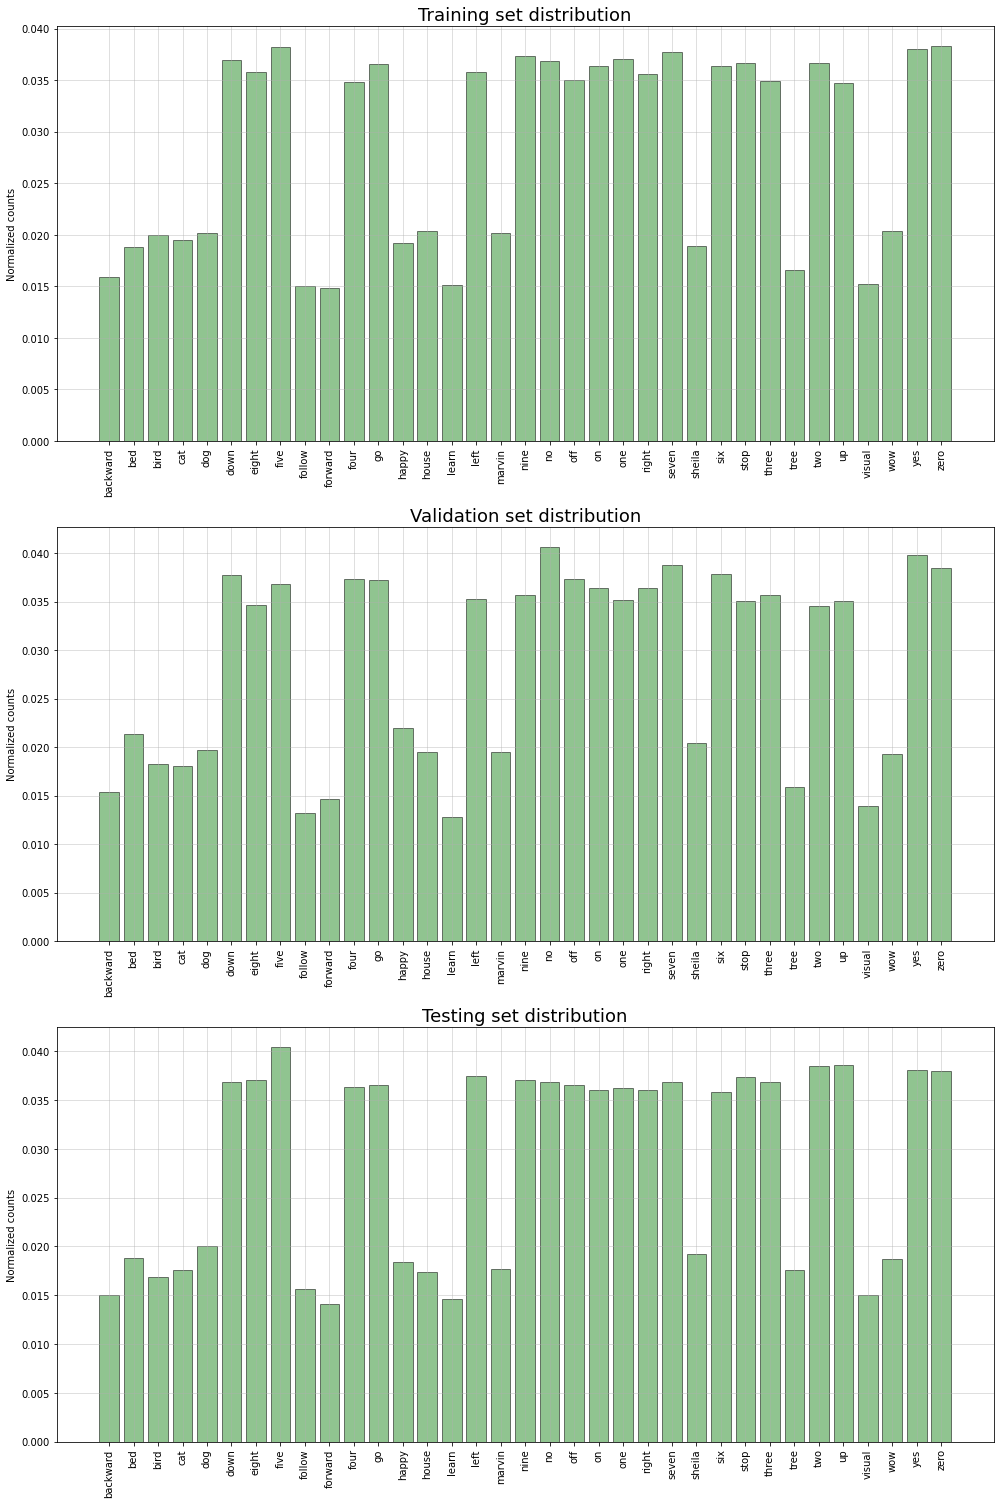

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(14, 21))

plot_utils.hist_class_distribution(reference_df_train, ax[0], commands)
plot_utils.hist_class_distribution(reference_df_val, ax[1], commands)
plot_utils.hist_class_distribution(reference_df_test, ax[2], commands)

for i in range(3):
    ax[i].set_ylabel('Normalized counts')
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(axis='x', labelrotation=90)
    
ax[0].set_title('Training set distribution', fontsize=18)
ax[1].set_title('Validation set distribution', fontsize=18)
ax[2].set_title('Testing set distribution', fontsize=18)

plt.tight_layout()
plt.show()

### 1.4 Noise loading 
We load here the available noisy audio signals and we defined the object `noise_dict`, which is required by the function `load_and_preprocessing_data` (see next section).

In [17]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = preprocessing_utils.load_data('doing_the_dishes.wav', noise_path)
noise_2 = preprocessing_utils.load_data('dude_miaowing.wav', noise_path)
noise_3 = preprocessing_utils.load_data('exercise_bike.wav', noise_path)
noise_4 = preprocessing_utils.load_data('pink_noise.wav', noise_path)
noise_5 = preprocessing_utils.load_data('running_tap.wav', noise_path)
noise_6 = preprocessing_utils.load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

/notebooks/preprocessing_utils.py:69: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. 

## 2.1 Loading and preprocessing
First, to load and preprocess the data, we use the function `load_and_preprocess_data`, defined in the file `preprocessing_utils.py`. This function puts together all loading and preprocessing methods that can be explored in the notebook `B1_data_analysis_and_preprocessing_inspection.ipynb`. 


In [18]:
print(inspect.getsource(preprocessing_utils.load_and_preprocess_data))

def load_and_preprocess_data(file_name, file_label, data_path_=data_path, apply_background_noise=False, noise_dict=None, noise_reduction=0.5, features=1, resize=False, random_shift=False):
    '''
    features:
    - 1 for MFCC features (default), delta_order=2
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    - 5 for MFCC features, delta_order=0
    '''
    
    # load data
    data = load_data(file_name, file_label, data_path_=data_path_)
    
    # padding/trimming
    data = padding_trimming(data)

    # random time shift
    if random_shift:
        data = random_time_shift(data)
    
    # add background noise
    if apply_background_noise and np.random.uniform()<0.8:
        data = background_noise(data, noise_dict=noise_dict, noise_reduction=noise_reduction)

    # extract features
    if features == 1:
        data_features = get_mfcc(data)
    
    elif features == 2:
        data_features = get_l

### 2.2 - Dataset definition
We now define the `create_dataset` function, which initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [19]:
def load_and_preprocess_noisedict_passed(file_name, file_label, data_path_=data_path, apply_background_noise=False, features=1, resize=False):
  return preprocessing_utils.load_and_preprocess_data(file_name, file_label, data_path_=data_path_, apply_background_noise=False, noise_dict=noise_dict, features=features, resize=resize)

In [20]:
def create_dataset(df, data_path_=data_path, apply_background_noise=False, features=1, resize=False, cache_file=None, shuffle=True, repeat=True, batch_size=32):

    # Convert DataFrame to lists
    file_names = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the load_and_preprocess_data function
    def numpy_func(file_name, file_label):
        return tf.numpy_function(load_and_preprocess_noisedict_passed, inp=[file_name, file_label, data_path_, apply_background_noise, features, resize], Tout=tf.float32), file_label
    dataset = dataset.map(numpy_func, num_parallel_calls=os.cpu_count())

    # Cache
    if cache_file:
        dataset = dataset.cache(filename=cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    # Repeat the dataset indefinitely
    if repeat:
        dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    # Steps
    steps = int(np.ceil(len(df) / batch_size))

    return dataset, steps

### 2.2 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).


In [21]:
'''
features:
- 1 for MFCC features (default), delta_order=2
- 2 for log Mel-filterbank energy features
- 3 for spectrogram
- 4 for Discrete Wavelet Transform + MFCC features
- 5 for MFCC features, delta_order=0
- 6 for log Mel-filterbank energy features (GAN)
'''

apply_bn = True
features_to_extract = 6
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train,
    apply_background_noise=apply_bn,
    features=features_to_extract,
    cache_file='train_cache',
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    apply_background_noise=apply_bn,
    features=features_to_extract,
    cache_file='val_cache',
    batch_size=batch_size
)

test_dataset, test_steps = create_dataset(
    reference_df_test,
    features=features_to_extract,
    cache_file='test_cache',
    shuffle=False,
    batch_size=batch_size
)

## 3 - GAN-based classifier model
References:
- [Deep Convolutional Generative Adversarial Network | TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan)
- [GAN-based Data Generation for Speech Emotion Recognition | Microsoft](https://isca-speech.org/archive_v0/Interspeech_2020/pdfs/2898.pdf)

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, UpSampling2D, LeakyReLU, Flatten, Activation, BatchNormalization

! pip install tensorflow-addons
from tensorflow_addons.layers import SpectralNormalization

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model

### 3.1 - Create the models

In [23]:
input_shape = (64, 64)

N_z = 128 # noise dimension
N_c = 35  # number of classes

use_large_models = False

#### 3.1.1 - Generator

In [24]:
def make_generator_model(name='generator', large=False):

    model = Sequential(name=name)

    if large:
        
        # 1st linear layer
        model.add(SpectralNormalization(Dense(4096, input_shape=(N_z + N_c,))))
        model.add(LeakyReLU())
        
        # 2nd linear layer
        model.add(SpectralNormalization(Dense(32768)))
        model.add(LeakyReLU())

        # intermediate representation reshaped into 8x8 images
        model.add(Reshape((8, 8, 512)))
        
        filter_sizes = [512, 256, 128]
    
    else:
        
        # 1st linear layer
        model.add(SpectralNormalization(Dense(1024, input_shape=(N_z + N_c,))))
        model.add(LeakyReLU())
        
        # 2nd linear layer
        model.add(SpectralNormalization(Dense(8192)))
        model.add(LeakyReLU())
        
        # intermediate representation reshaped into 8x8 images
        model.add(Reshape((8, 8, 128)))
        
        filter_sizes = [128, 64, 32]

    for filter_size in filter_sizes:

        # 1st convolutional layer
        model.add(SpectralNormalization(Conv2D(filter_size, (3, 3), strides=(1, 1), padding='same')))
        model.add(LeakyReLU())

        # 2nd convolutional layer
        model.add(SpectralNormalization(Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same')))
        model.add(LeakyReLU())
        
        # upsampling (nearest-neighbor interpolation)
        model.add(UpSampling2D(size=(4, 4), interpolation='nearest'))

    # last convolutional layer
    model.add(SpectralNormalization(Conv2D(1, (3, 3), strides=(1, 1), padding='same')))
    model.add(Activation('tanh'))

    return model

In [25]:
pt_generator = make_generator_model(name='pt_generator', large=use_large_models)

pt_generator.build(input_shape=(None, N_z + N_c,))
pt_generator.summary()

Model: "pt_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization (Spe  (None, 1024)             168960    
 ctralNormalization)                                             
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 spectral_normalization_1 (S  (None, 8192)             8404992   
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 spectral_normalization_2 (S  (None, 8, 8, 128)       

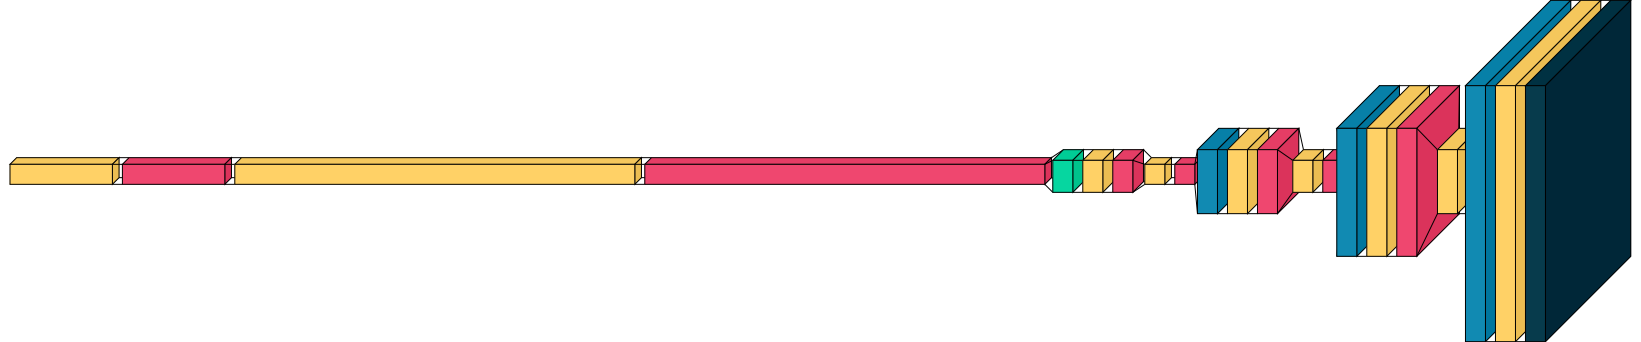

In [26]:
visualkeras.layered_view(pt_generator)

#### 3.1.2 - Discriminator

In [27]:
def make_discriminator_model(name='discriminator', large=False):

    model = Sequential(name=name)

    model.add(Reshape(input_shape=input_shape, target_shape=(input_shape[0], input_shape[1], 1)))
    model.add(BatchNormalization()) # !
    
    if large:

        filter_sizes = [128, 256, 512]
        
    else:
        
        filter_sizes = [32, 64, 128]

    for filter_size in filter_sizes:

        # 1st convolutional layer
        model.add(SpectralNormalization(Conv2D(filter_size, (3, 3), strides=(1, 1), padding='same')))
        model.add(LeakyReLU())

        # 2nd convolutional layer
        model.add(SpectralNormalization(Conv2D(filter_size, (3, 3), strides=(2, 2), padding='same')))
        model.add(LeakyReLU())

    # intermediate representation flattened
    model.add(Flatten())
    
    if large:

        # 1st linear layer
        model.add(SpectralNormalization(Dense(4096)))
        model.add(LeakyReLU())
        
    else:
        
        # 1st linear layer
        model.add(SpectralNormalization(Dense(1024)))
        model.add(LeakyReLU())

    # 2nd linear layer
    model.add(SpectralNormalization(Dense(1)))

    return model

In [28]:
pt_discriminator = make_discriminator_model(name='pt_discriminator', large=use_large_models)
    
pt_discriminator.build(input_shape=(None, input_shape[0], input_shape[0],))
pt_discriminator.summary()

Model: "pt_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 64, 64, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 1)        4         
 ormalization)                                                   
                                                                 
 spectral_normalization_9 (S  (None, 64, 64, 32)       352       
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 spectral_normalization_10 (  (None, 32, 32, 32)       9280      
 SpectralNormalization)                                          
                                                  

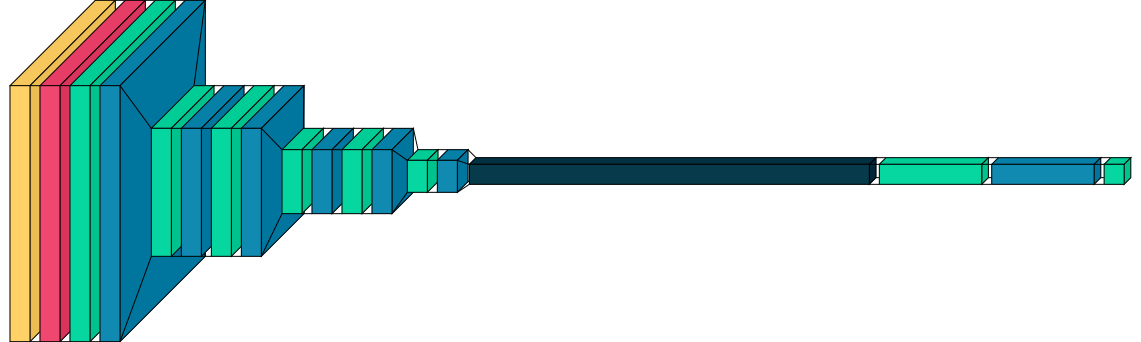

In [29]:
visualkeras.layered_view(pt_discriminator)

### 3.2 - Define the training loop

#### 3.2.1 - Build subclassed model

In [30]:
class GAN(Model):
    
    def __init__(self, generator, discriminator, fine_tuning, *args, **kwargs):
        
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        # create attributes for generator and discriminator
        self.generator     = generator
        self.discriminator = discriminator
        
        # create attribute for training type
        self.fine_tuning = fine_tuning
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        
        # compile with base class
        super().compile(*args, **kwargs)
        
        # create attributes for losses
        self.g_loss = g_loss
        self.d_loss = d_loss 
        
        # create attributes for optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt

    def train_step(self, batch, *args, **kwargs):
        
        # noise
        batch_size = tf.shape(batch[0])[0]
        noise      = tf.random.normal([batch_size, N_z])
        
        # condition vector
        if self.fine_tuning:
            code = tf.one_hot(batch[1], depth=N_c)
        else:
            code = tf.zeros([batch_size, N_c])

        # generator input
        g_input = tf.concat(values=[noise, code], axis=1)
        
        # get the data 
        real_images = batch[0]
        fake_images = self.generator(g_input, training=False)
        
        # train the discriminator
        with tf.GradientTape() as d_tape:
            
            # get the predicted labels
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat      = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # create the true labels
            y = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # add noise to the true labels
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y         += tf.concat([noise_real, noise_fake], axis=0)
            
            # calculate loss
            total_d_loss = self.d_loss(y, yhat)
            
        # apply backpropagation
        d_grad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))
        
        # train the generator 
        with tf.GradientTape() as g_tape:
            
            # generate new images
            gen_images = self.generator(g_input, training=True)
                                        
            # get the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # apply backpropagation
        g_grad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))
        
        return {"generator_loss":total_g_loss, "discriminator_loss":total_d_loss}

### 3.3 - Pre-training

#### 3.3.1 - Define losses and optimizers

In [31]:
g_loss = BinaryCrossentropy(from_logits=True)
g_opt  = Adam(learning_rate=2e-6, beta_1=0.5, beta_2=0.99)

In [32]:
d_loss = BinaryCrossentropy(from_logits=True)
d_opt  = Adam(learning_rate=2e-5, beta_1=0.5, beta_2=0.99)

#### 3.3.2 - Pre-train the GAN

In [33]:
# create instance of subclassed model
gan = GAN(pt_generator, pt_discriminator, fine_tuning=False)

# compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [34]:
# uncomment to remove cache files
#remove_file_starting_with('train_cache')

In [35]:
num_epochs = 50

g_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='generator_loss', patience=10)
d_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='discriminator_loss', patience=10)

hist = gan.fit(
            train_dataset,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            callbacks=[g_early_stopping, d_early_stopping]
            )

Epoch 1/50
2652/2652 [==============================] - 73s 24ms/step - generator_loss: 0.1809 - discriminator_loss: 0.2884
Epoch 2/50
2652/2652 [==============================] - 68s 26ms/step - generator_loss: 0.1262 - discriminator_loss: 0.2771
Epoch 3/50
2652/2652 [==============================] - 69s 26ms/step - generator_loss: 0.0974 - discriminator_loss: 0.2720
Epoch 4/50
2652/2652 [==============================] - 65s 24ms/step - generator_loss: 0.0973 - discriminator_loss: 0.2678
Epoch 5/50
2652/2652 [==============================] - 68s 26ms/step - generator_loss: 0.0811 - discriminator_loss: 0.2673
Epoch 6/50
2652/2652 [==============================] - 69s 26ms/step - generator_loss: 0.0625 - discriminator_loss: 0.2670
Epoch 7/50
2652/2652 [==============================] - 65s 24ms/step - generator_loss: 0.0704 - discriminator_loss: 0.2671
Epoch 8/50
2652/2652 [==============================] - 67s 25ms/step - generator_loss: 0.1013 - discriminator_loss: 0.2672
Epoch 9/

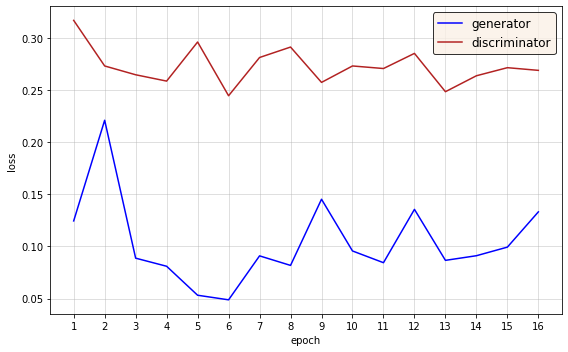

In [36]:
_, ax = plt.subplots(figsize=(8, 5))

ax.plot(hist.history['generator_loss'], label='generator', color='blue', linewidth=1.5)
ax.plot(hist.history['discriminator_loss'], label='discriminator', color='firebrick', linewidth=1.5)
ax.set_xticks(range(len(hist.history['generator_loss'])))
ax.set_xticklabels(range(1, len(hist.history['generator_loss'])+1))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(alpha=0.5)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='best')

plt.tight_layout()
plt.show()

Uncomment the cell below to save the weights of the trained models.

In [37]:
pt_generator.save_weights('pt_generator.h5')
pt_discriminator.save_weights('pt_discriminator.h5')

Uncomment the cell below to load pretrained models.

In [38]:
#pt_generator     = tf.keras.models.load_model('pt_generator.h5')
#pt_discriminator = tf.keras.models.load_model('pt_discriminator.h5')

### 3.4 - Fine-tuning

#### 3.4.1 - Create the final discriminator model

In [39]:
ft_discriminator = Sequential(name='ft_discriminator')

for i in range(len(pt_discriminator.layers) - 1):
    ft_discriminator.add(pt_discriminator.layers[i])

# unfreeze all layers
for layer in ft_discriminator.layers:
    layer.trainable = True

ft_discriminator.add(SpectralNormalization(Dense(N_c + 1)))
ft_discriminator.add(Activation('softmax'))

ft_discriminator.build(input_shape=(None, input_shape[0], input_shape[0],))
ft_discriminator.summary()

Model: "ft_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 64, 64, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 1)        4         
 ormalization)                                                   
                                                                 
 spectral_normalization_9 (S  (None, 64, 64, 32)       352       
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 spectral_normalization_10 (  (None, 32, 32, 32)       9280      
 SpectralNormalization)                                          
                                                  

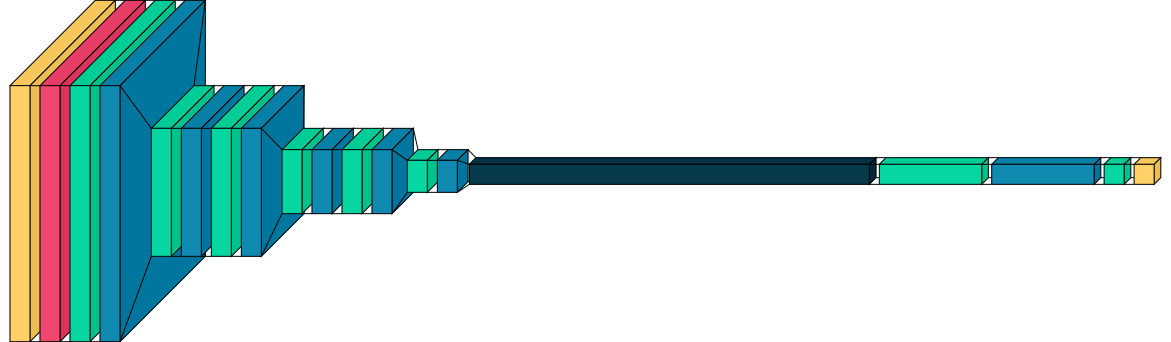

In [40]:
visualkeras.layered_view(ft_discriminator)

#### 3.4.2 - Define losses and optimizers

In [41]:
g_loss = BinaryCrossentropy(from_logits=True)
g_opt  = Adam(learning_rate=2e-6, beta_1=0.5, beta_2=0.99)

In [42]:
d_loss = CategoricalCrossentropy(from_logits=False)
d_opt  = Adam(learning_rate=2e-5, beta_1=0.5, beta_2=0.99)

#### 3.4.3 - Fine-tune the GAN

In [43]:
# create instance of subclassed model
gan = GAN(pt_generator, ft_discriminator, fine_tuning=True)

# compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [44]:
# uncomment to remove cache files
#remove_file_starting_with('train_cache')

In [45]:
num_epochs = 50

g_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='generator_loss', patience=10)
d_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='discriminator_loss', patience=10)

hist = gan.fit(
            train_dataset,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            callbacks=[g_early_stopping, d_early_stopping]
            )

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2652/2652 [==============================] - 73s 26ms/step - generator_loss: 0.6969 - discriminator_loss: 64.5021
Epoch 2/50
2652/2652 [==============================] - 68s 26ms/step - generator_loss: 0.6968 - discriminator_loss: 64.5044
Epoch 3/50
2652/2652 [==============================] - 65s 24ms/step - generator_loss: 0.6968 - discriminator_loss: 64.5023
Epoch 4/50
2652/2652 [==============================] - 69s 26ms/step - generator_loss: 0.6968 - discriminator_loss: 64.4998
Epoch 5/50
2652/2652 [==============================] - 68s 26ms/step - generator_loss: 0.6968 - discriminator_loss: 64.5016
Epoch 6/50
2652/2652 [==============================] - 65s 25ms/step - generator_loss: 0.6968 - discriminator_loss: 64.4990
Epoch 7/50
2652/2652 [==============================] - 69s 26ms/step - generator_loss: 0.6968 - discriminator_loss: 64.5024
Epoch 8/50
2652/2652 [==============================] - 68s 26ms/step - generator_loss: 0.6968 - discriminator_loss: 64.4991
Epoch 9/50


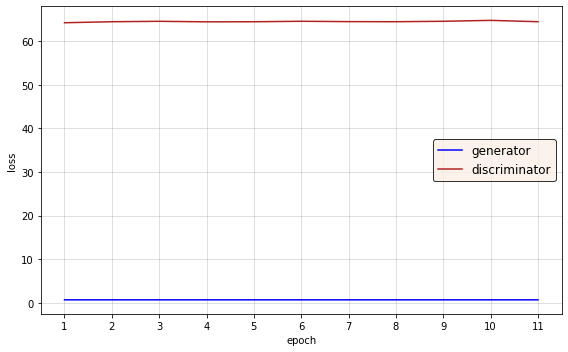

In [46]:
_, ax = plt.subplots(figsize=(8, 5))

ax.plot(hist.history['generator_loss'], label='generator', color='blue', linewidth=1.5)
ax.plot(hist.history['discriminator_loss'], label='discriminator', color='firebrick', linewidth=1.5)
ax.set_xticks(range(len(hist.history['generator_loss'])))
ax.set_xticklabels(range(1, len(hist.history['generator_loss'])+1))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(alpha=0.5)
ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='best')

plt.tight_layout()
plt.show()

Uncomment the cell below to save the weights of the trained models.

In [47]:
pt_generator.save_weights('ft_generator.h5')
ft_discriminator.save_weights('ft_discriminator.h5')

Uncomment the cell below to load pretrained models.

In [48]:
#pt_generator     = tf.keras.models.load_model('ft_generator.h5')
#ft_discriminator = tf.keras.models.load_model('ft_discriminator.h5')

In [2]:
model = ft_discriminator

## 4 - Model testing

### 4.2 - Validation metrics

In [50]:
# true labels
y_true = reference_df_test['class'].tolist()

# get predictions for test set
test_pred = model.predict(test_dataset, steps=test_steps, verbose=1)[:len(y_true)].squeeze()

# predicted labels
y_pred = np.argmax(test_pred, axis=1)

344/344 [==============================] - 1s 2ms/step


Then, to visualize the performance of the algorithm we plot the confusion matrix:

/notebooks/plot_utils.py:56: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


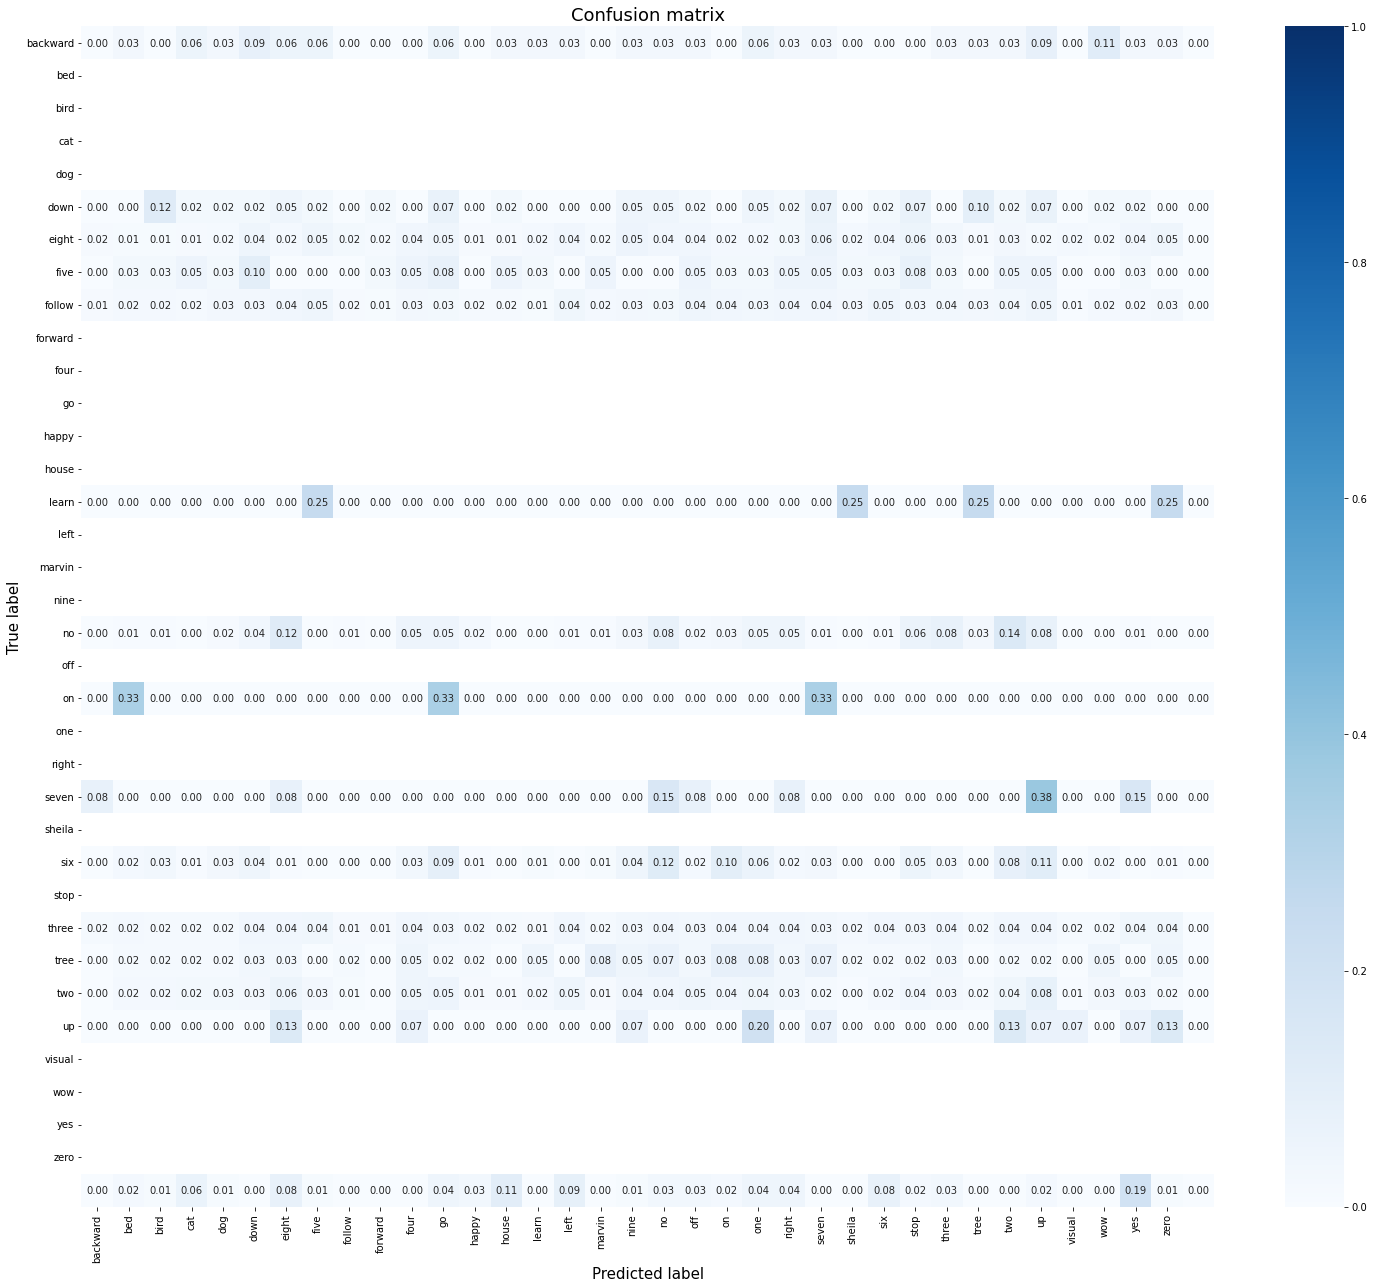

In [51]:
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands, normalize=True, saveit=False, model_name='')
# plt.savefig(f'figures/cm_{model_name}.png')

In [52]:
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(36))
cohen_k  = cohen_kappa_score(y_true, y_pred)

print('Accuracy:      {:.2f}%'.format(accuracy*100))
print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
print('Cross-entropy: {:.4f}'.format(logloss))
print("Cohen's Kappa: {:.4f}".format(cohen_k))

def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

cr = class_report(y_true, y_pred)
display(cr.round(4))

Accuracy:      3.25%
Error rate:    96.75%
Cross-entropy: 3.5835
Cohen's Kappa: -0.0020


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

,precision,recall,f1-score
macro,0.0079,0.0260,0.0062
micro,0.0325,0.0325,0.0325
weighted,0.0104,0.0325,0.0078


In [53]:
weighted_metrics = cr.iloc[-1].tolist()

df_metrics = pd.DataFrame(
    [weighted_metrics + [accuracy, logloss, cohen_k]], 
    columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa'], 
)

display(df_metrics.round(4))

# Uncomment next line to store the final metrics 
# df_metrics.to_csv(f'metrics/metr_{model_name}.csv')

,precision,recall,f1-score,accuracy,cross-entropy,Cohen-Kappa
0,0.0104,0.0325,0.0078,0.0325,3.5835,-0.002


# References
**[Sainath15]** <br>
Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.

**[Eskimez20]** <br>
Eskimez, Sefik & Dimitriadis, Dimitrios & Gmyr, Robert & Kumanati, Kenichi. (2020). _GAN-Based Data Generation for Speech Emotion Recognition_. 3446-3450. 10.21437/Interspeech.2020-2898. 
